### Notebook on the implementation of VQLS
- Equation to solve $Ax=b$
- Matrix $A$ assumed to be Hermitian and real
- $b$ assumed real 

In [79]:
import qiskit_aer
from qiskit import QuantumCircuit, quantum_info
from qiskit.circuit import Parameter
from qiskit.visualization import array_to_latex,plot_bloch_multivector,plot_state_qsphere,plot_distribution
from qiskit.visualization import plot_circuit_layout,plot_error_map

from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.result import marginal_counts

from qiskit.circuit.random import random_circuit
from qiskit import transpile
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import random

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth,FakeKolkataV2,FakeMumbaiV2, FakeBrisbane
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
plt.rcParams["figure.figsize"] = (6.0, 4.0)   # width, height in inches
plt.rcParams["figure.dpi"]     = 300 

### Define the problem ($A$ real and Hermitian):

In [80]:
#DEFINE 8x8 matrix 

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
Y = np.array([[0,-1j],[1j,0]])
pauli_mat = {0: I, 1: Z, 2: X, 3 : Y}

def kron3(code):
    return np.kron(np.kron(pauli_mat[code[2]], pauli_mat[code[1]]), pauli_mat[code[0]]) #ORDER IN PAULI MARTICES!!!!!
    
# A =  0.7 (IIZ)  + 0.4 (XII)  – 0.3 (ZXX)  + 0.2 (IXI)  + 0.1 (XXX)

# chosen_terms = {
#     (0,0,1):  0.7,    # I ⊗ I ⊗ Z
#     (2,0,0):  0.4,    # X ⊗ I ⊗ I
#     (1,2,2): -0.3,    # Z ⊗ X ⊗ X
#     (0,2,0):  0.2,    # I ⊗ X ⊗ I
#     (2,2,2):  0.1,    # X ⊗ X ⊗ X
# }

chosen_terms = {
    (0,0,1):  0.7j,    # I ⊗ I ⊗ Z
    (2,2,3):  0.1,    # X ⊗ X ⊗ Y
    (2,1,2):  -0.4j,    # X ⊗ I ⊗ X
}


A = sum(c * kron3(code) for code, c in chosen_terms.items())
b = np.array([9,5,4,6,2,8,7,5])
Nparam=len(chosen_terms) #number of non-zero coefficients
display(array_to_latex(A,prefix="A="))
xsol=sp.linalg.solve(A,b)
display(array_to_latex(xsol,prefix="x_{sol}="))
xsol_norm=xsol/sp.linalg.norm(xsol)
display(array_to_latex(xsol_norm,prefix="x_{sol;norm}="))
Nqubits=int(np.log2(len(A)))# for n-qubit register
nq=int(np.log2(len(A)))# for n-qubit register

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Now we define the different pieces for VQLS:
- Ansatz
- Hadamard test
- U gate that maps $|0\rangle$ into $|b\rangle$

In [81]:
def ansatz(nq,param): #this is now hard coded, works for 3 qubits.
    var=QuantumCircuit(nq)
    for ii in range(0,nq):
        var.ry(param[0][ii],ii )

    for ii in range(0,nq-1):
        var.cz(0, ii+1)

    for ii in range(0, nq):
        var.ry(param[1][ii], ii)

    for ii in range(0,nq-1):
        var.cz(ii,nq-1)

    for ii in range(0, nq):
        var.ry(param[2][ii], ii)
    Vtheta=var.to_gate(label='V(θ)')
    return Vtheta

def HadamardTest(nq,Ugate): #performs Hadamard test for a generic gate U that acts on nq qubits. First qubit aux
    qc=QuantumCircuit(nq+1,1)
    c_Ugate=Ugate.control()
    qc.x(0)
    qc.h(0)
    qc.append(c_Ugate,range(nq+1))
    qc.h(0)
    qc.measure(0,0)
    return qc

def HadamardTestCOM(nq,Ugate): #performs Hadamard test for a generic gate U that acts on nq qubits. First qubit aux
    qc=QuantumCircuit(nq+1,1)
    c_Ugate=Ugate.control()
    qc.x(0)
    qc.h(0)
    qc.s(0)
    qc.append(c_Ugate,range(nq+1))
    qc.h(0)
    qc.measure(0,0)
    return qc

def Utob(b):
    b/=sp.linalg.norm(b)
    nq=int(np.log2(len(b)))
    Ub=Initialize(b)
    Ubdag=Ub.gates_to_uncompute()
    return Ub,Ubdag

In [82]:
def run_fake(qc,backend=FakeBrisbane(),Nshots=1024,optim=2):
    qc_transpiled = transpile(qc, backend) 
    job = backend.run(qc_transpiled, shots = 1024)
    counts = job.result().get_counts()

    return counts

In [83]:
#Define the problem using An and cn: A=sum_n c_n A
An=np.zeros([Nparam,len(b),len(b)], dtype = complex)
cn=np.zeros([Nparam], dtype = complex)
ii=0
for code,c in chosen_terms.items():
    An[ii]=kron3(code)
    cn[ii]=c
    ii+=1
b=np.asarray(b,dtype=float)
Ub,Ubdag=Utob(b)

**Now we perform the VQLS, where we need to estimate the parameters $\Lambda_{n,m}$ and $\Gamma_{n}$ as defined in the notes (see overleaf, workplan)**. For that, we employ the Hadamard test, leading into $N+N(N-1)/2$ tests being $N$ the number of non-zero coefficients in the expansion of $A$. 

In [84]:
def VQLS_iter_COMPLEX(An,cn,param,Nshots=1024):
    nq=int(np.log2(len(A[0])))
    Vtheta=ansatz(nq,param)
    
    Lambda = np.zeros((Nparam, Nparam), dtype=complex) 
    Gamma  = np.zeros(Nparam, dtype=complex)

    
    for ii in range(Nparam-1):
        for jj in range(ii+1,Nparam):
            qc=QuantumCircuit(nq)
            qc.append(Vtheta,range(nq))
            qc.unitary(An[ii],range(nq))
            qc.unitary(np.transpose(np.conjugate(An[jj])),range(nq))
            qc.append(Vtheta.inverse(),range(nq))
            Uaux=qc.to_gate()
            
            p1_re = run_fake(HadamardTest(nq,Uaux), Nshots = Nshots).get('1',0)/Nshots

            p1_im = run_fake(HadamardTestCOM(nq,Uaux), Nshots = Nshots).get('1',0)/Nshots
    
            val = ((2*p1_re - 1) + 1j*(1-2*p1_im)) * np.conjugate(cn[ii]) * cn[jj]
    
            Lambda[ii, jj] = val
            Lambda[jj, ii] = np.conjugate(val)
    for n in range(Nparam):
        Lambda[n, n] = abs(cn[n])**2

    
    for ii in range(Nparam):
        qc=QuantumCircuit(nq)
        qc.append(Vtheta,range(nq))
        qc.unitary(An[ii],range(nq))
        qc.append(Ubdag,range(nq))
        Uaux=qc.decompose().to_gate()
        
        p1_re = run_fake(HadamardTest(nq,Uaux), Nshots = Nshots).get('1',0)/Nshots
        p1_im = run_fake(HadamardTestCOM(nq,Uaux), Nshots = Nshots).get('1',0)/Nshots
    
        Gamma[ii] = cn[ii] * ((2*p1_re - 1) + 1j*(1-2*p1_im))

    num = np.vdot(np.conjugate(cn) * Gamma,  cn * Gamma)
    den = np.conjugate(cn) @ (Lambda @ cn)
    overlap_sq = num / den
    fidelity   = float(abs(overlap_sq))

    return fidelity

def cost_function(flat_param):
    theta_mat  = flat_param.reshape(3,3) 
    cost_val   = 1 - VQLS_iter_COMPLEX(An, cn, theta_mat)
    cost_history.append(cost_val)
    print(cost_val)
    return cost_val

In [85]:
cost_history=[]
res=sp.optimize.minimize(cost_function,x0 = np.random.uniform(0, 2*np.pi, size=9),method='COBYLA',tol=1e-2,options={'rhobeg':np.pi/5,'maxiter':100, 'disp': True})

0.999617628360165
0.9969533222415659
0.9971910281906098
0.996924012989099
0.9924250113688167
0.999699549521751
0.9988571428141965
0.9998520842691745
0.9976984599280773
0.9964978105396609
0.9996302475061544
0.9989863224590358
0.9996821103841167
0.9986390679088549
0.9972127785578498
0.9997565675336129
0.9909099567941293
0.9985823622220138
0.9950236724128684
0.9963634141276397
0.9997701354616286
0.9983282056833217
0.9976896533840924
0.9968142152082903
0.9980365607456895
0.999033649437412
0.9983687706565363
0.9981413669299574
0.996944349988251
0.9954044662441057
0.998569657391114
0.9997294582140072
0.9995003264424474
0.9985836937372519
0.9989981693269334
0.9999802249667378
0.9996639674434813
0.9972698093916467
0.9995510801955418
0.9972082046470953
0.9974699373586031
0.996844097182456


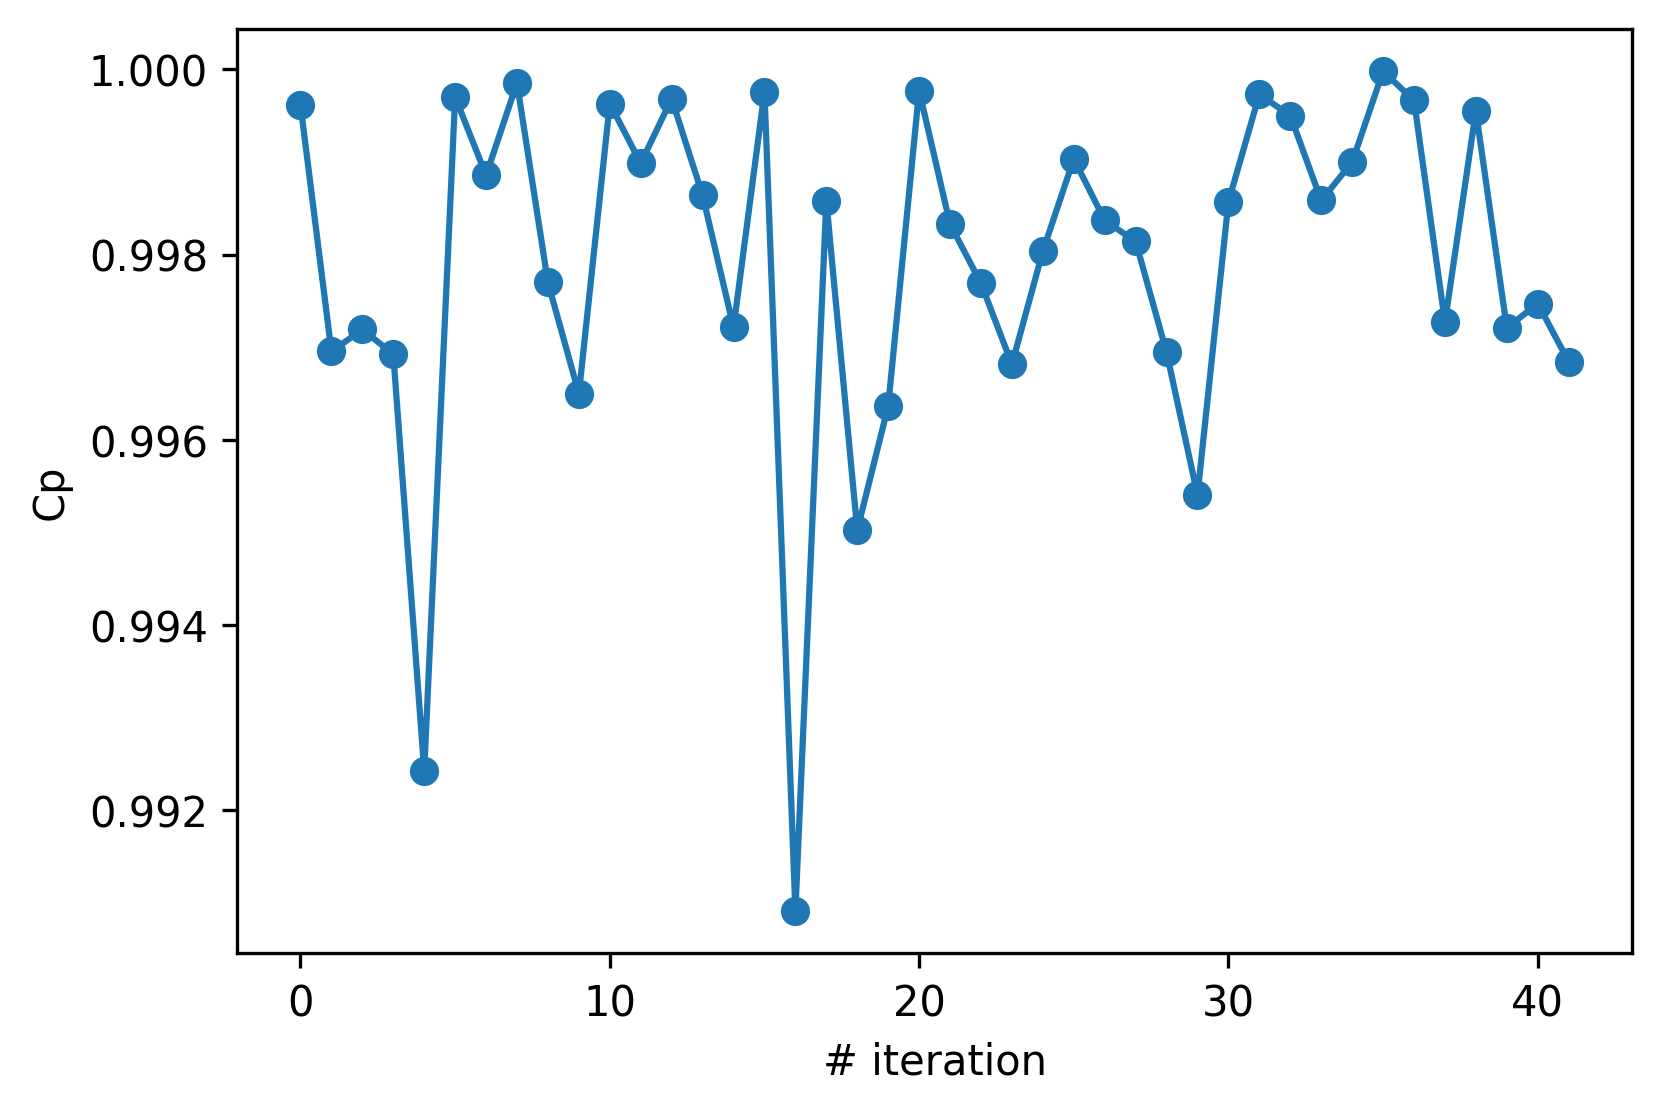

In [87]:
fig, ax1 = plt.subplots()
ax1.plot(cost_history, 'o-')
ax1.set_xlabel("# iteration")
ax1.set_ylabel("Cp")
plt.show()

In [88]:
fig.savefig("vqls_conv_fake4", dpi=300, bbox_inches="tight")
state_q = Statevector.from_instruction(qc)
fidelity = abs(np.vdot(xsol_norm, state_q.data))**2
fidelity

np.float64(0.011932814293079158)

In [78]:
#Now, let us check the solution found by VQLS:
Vthetasol=ansatz(Nqubits,res.x.reshape((3,3)))
qc=QuantumCircuit(Nqubits)
qc.append(Vthetasol,range(Nqubits))
psisol=quantum_info.Statevector(qc)
print(psisol)
print(xsol_norm)
print(psisol@xsol_norm)

Statevector([-0.49534065+0.j,  0.11060076+0.j,  0.43384471+0.j,
             -0.1374498 +0.j,  0.67859635+0.j, -0.0542662 +0.j,
             -0.24932821+0.j,  0.09843302+0.j],
            dims=(2, 2, 2))
[0.-0.24072905j 0.-0.22131542j 0.-0.28538041j 0.-0.50863719j
 0.+0.19801906j 0.+0.67365307j 0.+0.18248815j 0.+0.16307452j]
0.10923742166986164j
